## Import Package

In [10]:
import numpy as np
import pandas as pd
import random
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, FunctionTransformer
from sklearn.model_selection import KFold, StratifiedKFold, GroupShuffleSplit, GroupKFold, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.feature_selection import f_regression, SelectKBest, SelectPercentile, mutual_info_regression

plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 16

## Import Data and Data Manipulations

In [2]:
df = pd.read_csv("../data/cook_county_housing.csv", index_col='Unnamed: 0')

In [4]:
df.columns = df.columns.str.replace(" ", "")
#df.columns

In [5]:
df["LogSalePrice"] = np.log(df["SalePrice"])
df["LogBuildingSquareFeet"] = np.log(df["BuildingSquareFeet"])
df["Grp_LogSalePrice"] = np.zeros(df.shape[0])
df["Grp_LogSalePrice"][df["LogSalePrice"]<2.5] = "lessthan2.5"
df["Grp_LogSalePrice"][(df["LogSalePrice"]>=2.5) & (df["LogSalePrice"]<7.5)] = "between2.5and7.5"
df["Grp_LogSalePrice"][df["LogSalePrice"]>=7.5] = "over7.5"

In [6]:
Q1 = df["LogSalePrice"].quantile(0.25)
Q3 = df["LogSalePrice"].quantile(0.75)
IQR = Q3 - Q1
IQR

1.9319061009712968

In [7]:
outliers = ~((df["LogSalePrice"] < (Q1 - 1.5*IQR)) | (df["LogSalePrice"] > (Q3 + 1.5*IQR)))
df1 = df.copy()
df = df1.loc[outliers,]
df.shape

(168757, 65)

## Data Preprocessing

In [8]:
maxmin_ftr = ['Longitude','Latitude',]
std_ftr = ['Fireplaces','LandSquareFeet', 'Garage1Size', 'Garage2Size',
           "NumberofCommercialUnits", 
           'Estimate(Land)','Estimate(Building)', 'Age', 'SaleYear', 
           'SaleQuarter', 'SaleHalf-Year', 'AgeDecade', 'LotSize','LogBuildingSquareFeet']
no_need = ['PIN', 'DeedNo.', 'Description', 'SalePrice', 'LogSalePrice','CensusTract', 
           'SiteDesirability', 'OtherImprovements', 'ModelingGroup', "BuildingSquareFeet"]
ord_ftr = ["BasementFinish", "AtticType", "ConstructionQuality", "RepairCondition", "Floodplain"]
onehot_ftr = ["PropertyClass","NeighborhoodCode", "TownCode", "Apartments" ,"WallMaterial", "RoofMaterial","Basement", 
              "CentralHeating", "OtherHeating", "CentralAir", "AtticFinish", "DesignPlan", "CathedralCeiling",
              "Garage1Material", "Garage1Attachment", "Garage1Area", 
              "Garage2Material", "Garage2Attachment", "Garage2Area", 
              "Porch", "MultiCode", "MultiPropertyIndicator", "Use", "O'HareNoise", "RoadProximity", 
              "SaleQuarterofYear", 'SaleMonthofYear', 'SaleHalfofYear', "MostRecentSale", "PureMarketFilter", 
              "GarageIndicator", "NeigborhoodCode(mapping)", "TownandNeighborhood"]

ord_cat = [[1.0, 2.0, 3.0], [1.0, 2.0, 3.0], [1.0, 2.0, 3.0], [1.0, 2.0, 3.0], [0.0, 1.0]]

In [9]:
X = df.loc[:, ((df.columns != "Grp_LogSalePrice"))]
X = X.drop(columns = no_need)
y = df["LogSalePrice"]

## Feature Selection

In [395]:
X = df.loc[:, ((df.columns != "Grp_LogSalePrice"))]
X = X.drop(columns = no_need)
y = df["LogSalePrice"]

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftr),
        ('minmax', MinMaxScaler(), maxmin_ftr),
        ('std', StandardScaler(), std_ftr),
        ('ord', OrdinalEncoder(categories = ord_cat), ord_ftr)])

clf = Pipeline(steps=[('preprocessor', preprocessor)])


original_prep = clf.fit_transform(X)
feature_names = list(preprocessor.named_transformers_['onehot'].get_feature_names(onehot_ftr)) + preprocessor.transformers_[1][-1] + \
preprocessor.transformers_[2][-1] + preprocessor.transformers_[3][-1]
df_original_prep = pd.DataFrame(data = original_prep, columns = feature_names)

f_selector = SelectPercentile(f_regression, percentile = 66)
f_selector.fit_transform(df_original_prep, y)
f_sel_66per = list(np.array(feature_names)[(f_selector.get_support())])

In [12]:
indices = [i for i in range(len(feature_names)) if ((f_selector.get_support())[i] == True)]

## Model Training

In [256]:
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftr),
        ('minmax', MinMaxScaler(), maxmin_ftr),
        ('std', StandardScaler(), std_ftr),
        ('ord', OrdinalEncoder(categories = ord_cat), ord_ftr)])

def MLpipe_strKFold_RMSE(X, y, preprocessor, ML_algo, parameter_grid, strati_tar, num_folds):
    best_models = []
    test_scores = []
    state_lst = [random.randint(0, 1000) for _ in range(5)]
    
    for state in state_lst:
        pipe = Pipeline(steps = [('preprocessor', preprocessor),
                                 ('regressor', ML_algo)])
        X_other, X_test, y_other, y_test = train_test_split(X, y, test_size= 0.20, 
                                                            random_state = state, stratify = strati_tar)
        kf = KFold(n_splits = num_folds, shuffle = True, random_state=state)
        grid = GridSearchCV(pipe, param_grid = parameter_grid,
                           scoring = make_scorer(mean_squared_error, greater_is_better = False, squared = False),
                           cv = kf, return_train_score = True, n_jobs = -1, verbose = True)
        grid.fit(X_other, y_other)
        predictions = grid.predict(X_test)
        best_model = grid.best_params_
        test_score = mean_squared_error(y_test, predictions, squared = False)
        best_models.append(best_model)
        test_scores.append(test_score)
    return grid, X_other, y_other, X_test, y_test, best_models, test_scores, predictions

In [190]:
grid_ridge.score

<bound method BaseSearchCV.score of GridSearchCV(cv=KFold(n_splits=4, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('onehot',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['PropertyClass',
                                                                          'NeighborhoodCode',
                                                                          'TownCode',
                                                                          'Apartments',
                                                                          'WallMaterial',
                                                                          'RoofMaterial',
       

#### Lasso

In [396]:
# Don't run this
from sklearn.linear_model import Lasso

regressor = Lasso(max_iter=100000)
alpha = [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
param_grid = {"regressor__alpha": alpha}
grid_lasso, X_train_lasso, y_train_lasso, X_test_lasso, y_test_lasso, models_lasso, scores_lasso, predictions_lasso = MLpipe_strKFold_RMSE(X, y, 
                                                                                          preprocessor, regressor, param_grid, df["Grp_LogSalePrice"], 4)

Fitting 4 folds for each of 7 candidates, totalling 28 fits
Fitting 4 folds for each of 7 candidates, totalling 28 fits
Fitting 4 folds for each of 7 candidates, totalling 28 fits
Fitting 4 folds for each of 7 candidates, totalling 28 fits
Fitting 4 folds for each of 7 candidates, totalling 28 fits


In [397]:
np.std(scores_lasso)

0.0017801318522684788

#### RF

In [404]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor()
grid = {'regressor__n_estimators': [10, 100, 300, 500, 1000],
       'regressor__max_depth': [10, 30, 50, 70]}
grid_rf, X_train_rf, y_train_rf, X_test_rf, y_test_rf, models_rf, scores_rf, predictions_rf = MLpipe_strKFold_RMSE(X, y, 
                                                                                          preprocessor, regressor, grid, df["Grp_LogSalePrice"], 4)


Fitting 4 folds for each of 20 candidates, totalling 80 fits
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Fitting 4 folds for each of 20 candidates, totalling 80 fits


In [399]:
scores_rf

[0.8414544439235996,
 0.664592487162506,
 0.3831771350766662,
 0.4046785087634537,
 0.583304312034041]

#### Ridge

In [ ]:
from sklearn.linear_model import Ridge
regressor = Ridge(max_iter = 1000000)
grid = {"regressor__alpha": alpha}
grid_ridge, X_train_ridge, y_train_ridge, X_test_ridge, y_test_ridge, models_ridge, scores_ridge, predictions_ridge = MLpipe_strKFold_RMSE(X, y, preprocessor, 
                                                                                          regressor, grid, df["Grp_LogSalePrice"], 4)


In [ ]:
models_ridge, np.std(scores_ridge + scores_lasso + scores_svr)

#### SVR

In [ ]:
from sklearn.svm import SVR
regressor = SVR()
grid = {'regressor__C': [1e-2, 1e-1, 1e1, 1e2],
       'regressor__gamma': [1e-2, 1e-1, 1e1, 1e2]}
grid_svr, X_train_svr, y_train_svr, X_test_svr, y_test_svr, models_svr, scores_svr, predictions_svr = MLpipe_strKFold_RMSE(X, y, preprocessor, regressor, grid, df["Grp_LogSalePrice"], 4)


In [360]:
models_svr, scores_svr

([{'regressor__C': 10.0, 'regressor__gamma': 0.01},
  {'regressor__C': 10.0, 'regressor__gamma': 0.01},
  {'regressor__C': 10.0, 'regressor__gamma': 0.01},
  {'regressor__C': 10.0, 'regressor__gamma': 0.01},
  {'regressor__C': 10.0, 'regressor__gamma': 0.01}],
 [0.4766478367318136,
  0.43163849960828793,
  0.5159086431084797,
  0.46318231662846737,
  0.4456768768136763])

## results

In [365]:
baseline_regression = np.mean(y)
#mean_squared_error(y, baseline_regression)
baseline_regression

12.172362256564544

In [35]:
baseline_pred = [baseline_regression for i in range(168757)]

In [55]:
baseline_rmse = mean_squared_error(y, baseline_pred, squared = False)

In [59]:
np.std(np.sqrt(((y - baseline_pred)**2)))

0.6527856116663571

In [384]:
(baseline_rmse - hist_ridge)/(np.std(np.sqrt(((y - baseline_pred)**2))))

0.916775649675523

In [385]:
hist_lasso = np.mean(scores_lasso)
hist_rf = np.mean(scores_rf)
hist_ridge = np.mean(scores_ridge)
hist_svr = np.mean(scores_svr)
y = [hist_lasso, hist_rf, hist_ridge, hist_svr]

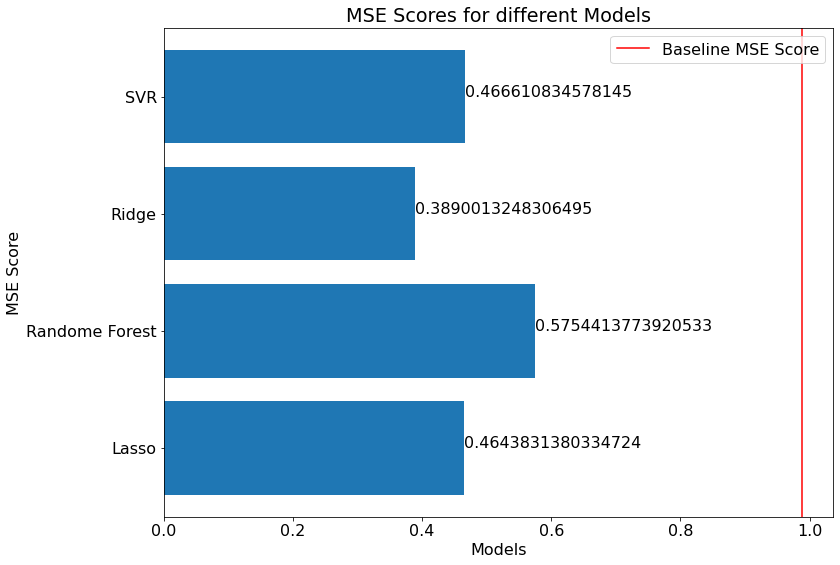

In [390]:
plt.barh(range(4), [hist_lasso, hist_rf, hist_ridge, hist_svr])
plt.yticks(range(4), ["Lasso", "Randome Forest", "Ridge", "SVR"])
plt.axvline(baseline_rmse, label = "Baseline MSE Score", color = "red")
plt.xlabel("Models")
plt.ylabel("MSE Score")
plt.title("MSE Scores for different Models")
plt.legend()
for index, value in enumerate(y):
    plt.text(value, index, str(value))
plt.show();
#plt.savefig('../data/histogram_mse.png')

#### Global Feature Importances

##### Coefficients

In [172]:
coefs = grid_ridge.best_estimator_[-1].coef_

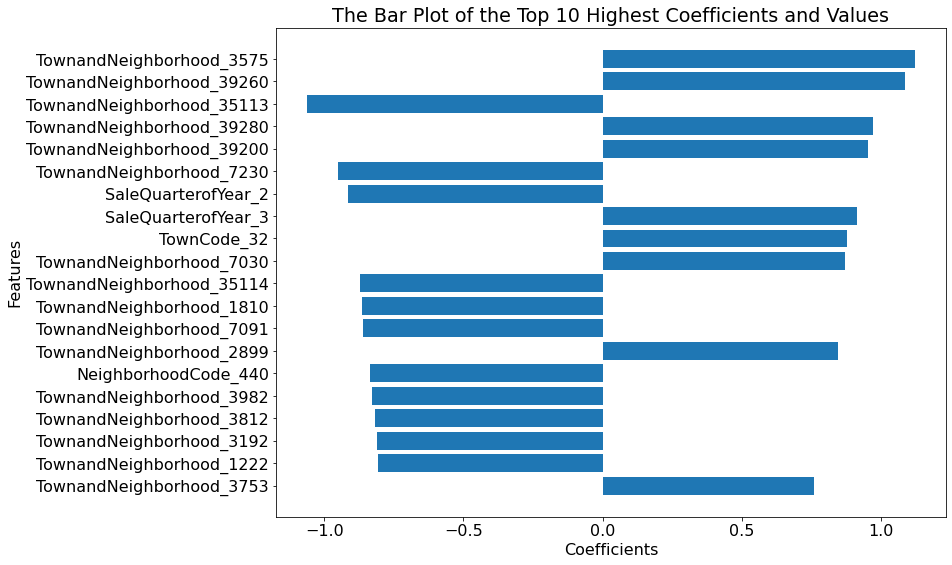

In [402]:
sorted_coefs = np.argsort(np.abs(coefs))
plt.barh(np.arange(20), coefs[sorted_coefs[-20:]])
plt.yticks(np.arange(20), [feature_names[i] for i in sorted_coefs[-20:]])
plt.xlabel("Coefficients")
plt.ylabel("Features")
plt.title("The Bar Plot of the Top 10 Highest Coefficients and Values");

##### Permutation Featrue Importance

In [214]:
ftr_names = X.columns
ftr_names

Index(['PropertyClass', 'NeighborhoodCode', 'LandSquareFeet', 'TownCode',
       'Apartments', 'WallMaterial', 'RoofMaterial', 'Basement',
       'BasementFinish', 'CentralHeating', 'OtherHeating', 'CentralAir',
       'Fireplaces', 'AtticType', 'AtticFinish', 'DesignPlan',
       'CathedralCeiling', 'ConstructionQuality', 'Garage1Size',
       'Garage1Material', 'Garage1Attachment', 'Garage1Area', 'Garage2Size',
       'Garage2Material', 'Garage2Attachment', 'Garage2Area', 'Porch',
       'RepairCondition', 'MultiCode', 'NumberofCommercialUnits',
       'Estimate(Land)', 'Estimate(Building)', 'Longitude', 'Latitude',
       'MultiPropertyIndicator', 'Age', 'Use', 'O'HareNoise', 'Floodplain',
       'RoadProximity', 'SaleYear', 'SaleQuarter', 'SaleHalf-Year',
       'SaleQuarterofYear', 'SaleMonthofYear', 'SaleHalfofYear',
       'MostRecentSale', 'AgeDecade', 'PureMarketFilter', 'GarageIndicator',
       'NeigborhoodCode(mapping)', 'TownandNeighborhood', 'LotSize',
       'LogBuilding

In [216]:
X_test_ridge_trans

array([[0., 1., 0., ..., 1., 1., 0.],
       [0., 1., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 1., 0., ..., 1., 1., 0.],
       [0., 1., 0., ..., 1., 1., 0.]])

In [222]:
np.random.seed(42)
nr_runs = 10
scores = np.zeros([len(ftr_names), nr_runs])

for i in range(len(ftr_names)):
    acc_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test_ridge.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test_ridge[ftr_names[i]].values)
        acc_scores.append(np.abs(grid_ridge.score(X_test_shuffled, y_test_ridge)))
    scores[i] = acc_scores

In [223]:
test_score_ridge = np.abs(grid_ridge.score(X_test_ridge, y_test_ridge))

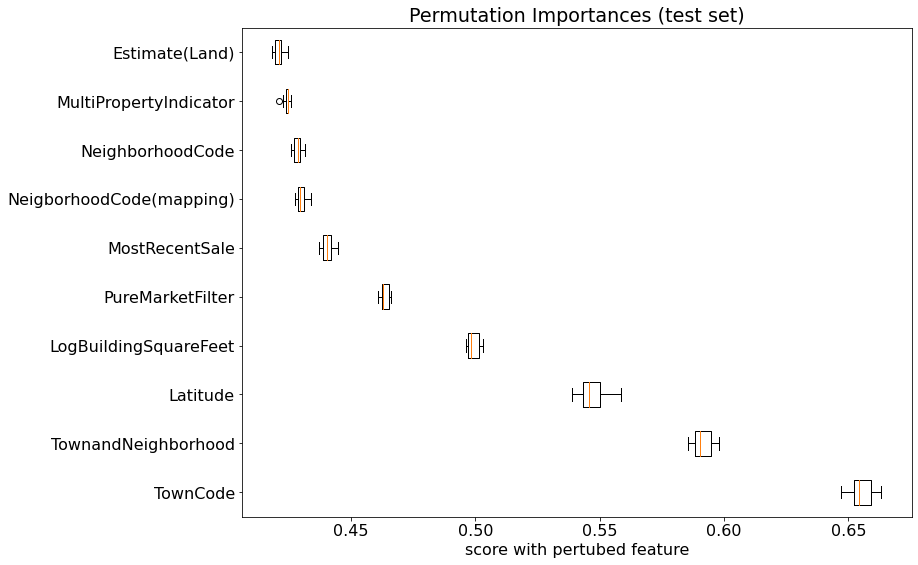

In [225]:
sorted_indices = np.argsort(np.mean(scores, axis = 1))[::-1][:10]
plt.boxplot((scores[sorted_indices].T)[:10], labels = ftr_names[sorted_indices], vert = False)
plt.title("Permutation Importances (test set)")
plt.xlabel("score with pertubed feature")
plt.show()

##### Global -- Shape Values

In [304]:
X_test_ridge

,PropertyClass,NeighborhoodCode,LandSquareFeet,TownCode,Apartments,WallMaterial,RoofMaterial,Basement,BasementFinish,CentralHeating,...,SaleMonthofYear,SaleHalfofYear,MostRecentSale,AgeDecade,PureMarketFilter,GarageIndicator,NeigborhoodCode(mapping),TownandNeighborhood,LotSize,LogBuildingSquareFeet
8238,203,190,6528.0,12,0.0,2.0,1.0,1.0,1.0,1.0,...,3,1,1.0,2.4,1,1.0,190,12190,6528.0,7.363914
8310,206,85,14700.0,12,0.0,2.0,1.0,1.0,3.0,2.0,...,12,2,1.0,9.0,1,1.0,85,1285,14700.0,8.014997
6527,203,31,5280.0,31,0.0,2.0,1.0,3.0,1.0,1.0,...,4,1,1.0,8.8,1,1.0,31,3131,5280.0,6.973543
4415,203,330,7750.0,72,0.0,2.0,1.0,1.0,1.0,1.0,...,8,2,1.0,5.8,1,1.0,330,72330,7750.0,7.131699
1629,203,221,4375.0,72,0.0,2.0,1.0,1.0,3.0,1.0,...,8,2,1.0,9.5,1,0.0,221,72221,4375.0,7.275865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5609,203,71,3906.0,71,0.0,1.0,1.0,1.0,3.0,1.0,...,9,2,1.0,9.0,1,0.0,71,7171,3906.0,7.129298
4474,203,53,5040.0,37,0.0,2.0,1.0,1.0,3.0,1.0,...,8,2,1.0,4.3,1,0.0,53,3753,5040.0,7.125283
9252,203,260,3720.0,71,0.0,2.0,1.0,1.0,3.0,2.0,...,12,2,0.0,8.7,1,1.0,260,71260,3720.0,7.197435
4975,203,13,4234.0,77,0.0,4.0,1.0,1.0,1.0,2.0,...,10,2,1.0,10.5,1,1.0,13,7713,4234.0,7.101676


In [218]:
X_test_ridge_trans = grid_ridge.best_estimator_[0].transform(X_test_ridge)
X_train_ridge_trans = grid_ridge.best_estimator_[0].transform(X_train_ridge)

In [319]:
np.shape(X_test_ridge_trans)

(2000, 1268)

In [320]:
np.shape(shapval)

(2000, 1268)

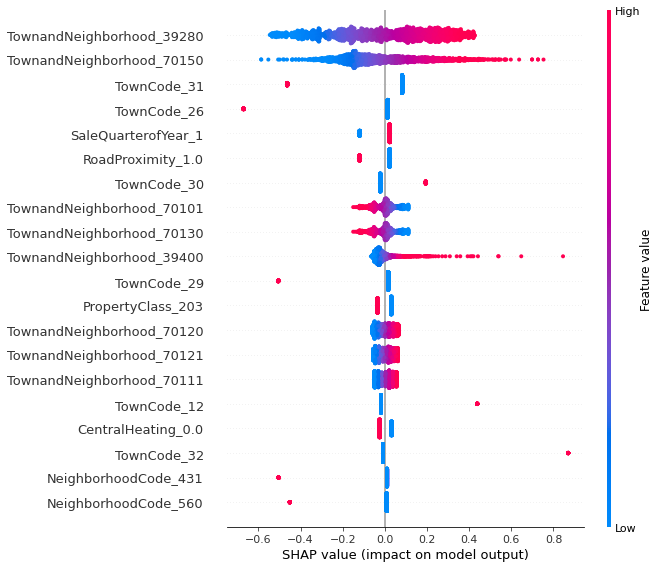

In [318]:
import shap
shap.initjs()
#ridge_regressor = Ridge(max_iter=100000, alpha = 1.0)
#ridge_regressor.fit(X_train_ridge_trans, y_train_ridge)
grid_ridge.best_estimator_[0].transform(X_test_ridge)
explainer = shap.LinearExplainer(ridge_regressor, X_test_ridge_trans)
shapval = explainer.shap_values(X_test_ridge_trans)
shap.summary_plot(shapval, X_test_ridge_trans, feature_names=feature_names)

In [240]:
shapval

array([[ 0.01178291, -0.03468078,  0.00782809, ...,  0.00038471,
        -0.        ,  0.00057384],
       [ 0.01178291, -0.03468078,  0.00782809, ...,  0.00038471,
        -0.        ,  0.00057384],
       [ 0.01178291,  0.03075465,  0.00782809, ...,  0.00038471,
        -0.        ,  0.00057384],
       ...,
       [ 0.01178291,  0.03075465,  0.00782809, ...,  0.00038471,
        -0.        ,  0.00057384],
       [ 0.01178291, -0.03468078,  0.00782809, ...,  0.00038471,
        -0.        ,  0.00057384],
       [ 0.01178291, -0.03468078,  0.00782809, ...,  0.00038471,
        -0.        ,  0.00057384]])

#### Local Shap

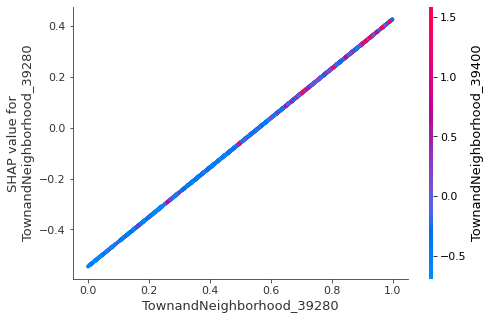

In [333]:
ftr = "TownandNeighborhood_39280"
shap.dependence_plot(ftr, shapval, X_test_ridge_trans, feature_names=feature_names)

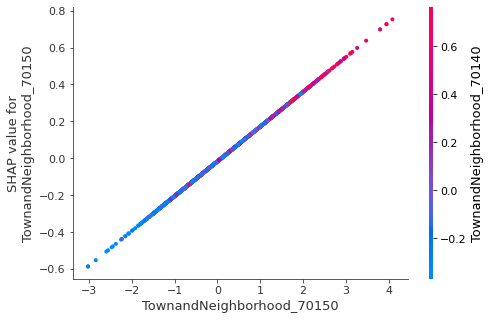

In [339]:
ftr = "TownandNeighborhood_70150"
shap.dependence_plot(ftr, shapval, X_test_ridge_trans, feature_names=feature_names)

In [403]:
len(feature_names)

1380